# Numerical Solutions to ODEs

*Before starting, I expect the reader to have basic knowledge of ordinary differential equations. The following notebook explains the numerical methods with some sort of detail and rigor, but it should NOT be treated as a substitute for academic material. All the explanations and codes are written just for personal and illustrative purposes.*


## What Do We Mean By Numerical Solutions?

ODEs are freaking hard. No wonder people usually study them at university: you need to have many prerequisites. On top of that, the actual equations are not that immediate to solve. Even more: some of them might not have a solution.

**Wait. What?**

Yes. Unless in some special form, most problems are analytically untractable and do not produce an explicit solution. For example, we cannot find an explicit function $y(t)$ that solves the following equation:
$$
\frac{dy}{dt} = \sin\left(y(t)\cdot t\right)
$$

which seems pretty basic. Nonetheless, we have a great tool that can help us in such scenarios: **APPROXIMATION**. Think about it, any model - economical, mathematical, physical, statistical, you name it - is an approximation of the truth. This is, indeed, the rationale behind numerical solutions: with a particular type of approximation, we will be able to find an approximately good solution to those ODEs that have no explicit solution. *Or rather, to those equations that we don't know yet how to write with an explicit solution.*

To date, there are many methods used to approximate the solutions of differential equations. Let's go over **Euler's method**, one of the most basic and well-known methods, whose simplicity allows issues to come through more easily!

### Notation
To simplify notation, from now on I will drop the dependence on time $t$ and write the derivatives according to their order. So the above equation would be $y' = \sin\left(yt\right)$ for example.


## Euler's Method

Consider the Cauchy Problem (CP)
$$
\begin{cases}
    y' = f(y,t) \\
    y(t_0) = y_0
\end{cases}
$$

What we want to do is simulate the system as time goes on, so find an approximation of $y$ for $t\ge t_0$. To simplify, let's assume that $t_0 = 0$, so that we study $y$ for $t\ge 0$. In fancy words, we want to predict the future, starting from the present. 

The information provided in the CP is enough for us to get an initial approximation of the tangent line to the solution at a generic point $t$. As a matter of fact,
$$
y'(t) = \lim_{h \to 0}\frac{y(t+h) - y(t)}{h}
$$
Since the concept of limit is cumbersome, we drop it and write instead
$$
y'(t) \simeq \frac{y(t+h) - y(t)}{h}
$$
Since $y'=f(y,t)$, doing some mathematical kung-fu we can write that
$$
y(t+h) \simeq y(t) + f(y,t)\cdot h
$$
This last equation is the essence of Euler's method. It is an iterative method that, given a solution at a time $t$, computes an approximation at a later time $t+h$, where $h\gt0$ is called "_step-size_". What we will do later is iterate this relation over and over with some code, but first, let's clarify 2 things:
* We're not finding $y$, but an approximation. Indeed to begin the iteration we just need to start at $t=0$ since we have the initial condition in the CP

* We don't care about the whole behaviour of the solution, but only at each time step. This means that we analyze discrete, and not continuous, time. That is why we get an approximation.

Starting from the first step, we get $y(h) \simeq  y(0) + h\cdot f(0,y(0)) = b + h\cdot f(0,b)$. This is an approximation, so we're surely going to be far away from the exact value at $t=0$, yet this is the only thing we know at this point.

So, **proceeding by desperation**, we will use the previous equation as a starting point for another iteration of Euler's method. In other words, we will have $y(2h) \sim y(h) + h\cdot f(h, y(h))$
We iterate again to get the next step and go on, and on, and on, and on...

Since the step-size $h$ is a positive integer, any specific time $t$ will be in $\{nh: n = 0,1,\dots \}$. So, we can describe the problem with a difference equation using sequence $(y_n)_{n\ge 0}$ as follows:

$$
\begin{cases}
y_0 = b \\
y_{n+1} = y_n + h\cdot f(nh, y_n)
\end{cases}
$$

Given this description, we see $y_n$ as an approximation of $y(nh)$, so of the original function $y(t)$ after $n$ steps of size $h$.

### Pseudocode

Done with the boring math. Let's look at how to implement it with some pseudocode.

- **Given**: $f(t,y), t_0$, $y_0$, number of steps $n$, step-size $h$
- **Output**: Approximation of $y$ with respective time steps
- **Code**:
    - initialize emtpy list _time_ that collects the time steps
    - initialize empty list _approximation_ that collects the values calculated with the difference formula at each time step
    - _time_[0] = $t_0$
    - _approximation_[0] = $y_0$
    - for $i$ from $1$ to $n$:
        - $y_1 = y_0 + h \cdot f(t_0, y_0)$
        - $t_0 = t_0 + h$
        - $y_0 = y_1$
    - return _time_, _approximation_
    - **end**


Note that instead of having $n$ as an input, we might also have the time $T$ at which to stop the iteration. In this case we easily recover $n = \frac{T-t_0}{h}$.

As we can see the implementation is trivially trivial and trivially fast (it's $O(n)$). That is thanks to the triviality of the Euler method itself! However, I ought to make some fundamental remarks:
* **Computational time**: Each step takes computer time. Even if the function is simple to compute, we do it many times over. Large step size means faster computation, but perhaps not the right precision.

* **Roundoff errors**: Computers only compute with a certain number of significant digits. Errors introduced by rounding numbers off during our computations become noticeable when the step size becomes too small relative to the quantities we are working with. So reducing step size may in fact make errors worse. There is a certain optimum step size such that the precision increases as we approach it, but then starts getting worse as we make our step size smaller still. Trouble is: this optimum may be hard to find.

* **Stability**: Certain equations may be numerically unstable. What may happen is that the numbers never seem to stabilize no matter how many times we halve the interval. We may need a ridiculously small interval size, which may not be practical due to roundoff errors or computational time considerations. Such problems are sometimes called *stiff*. In the worst case, the numerical computations might be giving us bogus numbers that look like a correct answers. Just because the numbers seem to have stabilized after successive halving, does not mean that we must have the right answer. We'll see an example later on...

### Code

In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt

def euler(f, t0, y0, T, h):
    """
    Euler method to solve ODEs
    
        Parameters:
            f: the input function, depending on y and t
            t0 (int): initial time
            T (float or int): final time
            y0 (float): initial condition for y(t0)
            h (float): step-size
            
        Returns:
            time (np.array): it includes all the recursive time steps
            y_approx (np.array): it includes all evaluations of the sequence
    """
    
    n = floor((T-t0)/h) #time steps
    time = np.zeros(n)
    y_approx = np.zeros(n)
    
    #initial conditions
    time[0] = t0
    y_approx[0] = y0
    
    for i in range(n - 1):
        y_approx[i + 1] = y_approx[i] + h * f(time[i], y_approx[i])
        time[i + 1] = time[i] + h
        
    return time, y_approx    

### Examples

Now let's jump into the actual code with some practical examples.

#### Example 1: The Logistic Equation

$$
\begin{cases}
y' = y(1-y) \\
y(0) = 0.1
\end{cases}
$$

with $T = 5$ and $h = 0.1$. I'll start with this example because we actually know an explicit solution for this and we will be able to compare the approximation with the correct function.

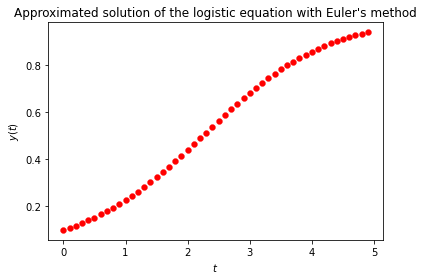

In [2]:
#defining the generatrix function of the logistic
def logistic(t,y):
    return y * (1 - y)

#defining the constant
t0 = 0
y0 = 0.1
T = 5
h = 0.1

time, y_approx = euler(logistic, t0, y0, T, h)

plt.scatter(time, y_approx, color = "red", linewidth = 0.3)
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.title("Approximated solution of the logistic equation with Euler's method")
plt.show()

The logisitic equation is separable and autonomous, so, doing some ODE kung-fu, we can write an explicit solution as

$$
y(t) = \frac{y_0e^t}{1-y_0+y_0e^t}
$$

Let's compare it to the approximation we calculated and find what the error is.

The maximal error is 0.012795629295983824
The average error is 0.006083466168148353


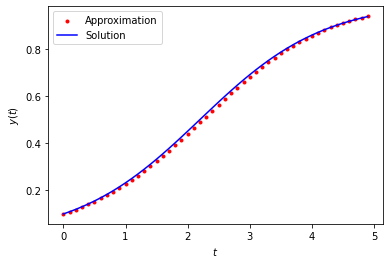

In [3]:
solution = (y0 * np.exp(time))/(1 - y0 + y0 * np.exp(time))

max_error = np.max(np.abs(y_approx - solution))
avg_error = np.mean(np.abs(y_approx - solution))
print(f"The maximal error is {max_error}\nThe average error is {avg_error}")

plt.scatter(time, y_approx, label = "Approximation", color = "red", marker = ".")
plt.plot(time, solution, label = "Solution", color = "blue")
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.legend()
plt.show()

It seems like the approximation is very accurate and really close to the actual solution!

Now it would interesting to see what would happen if we decreased the step-size from $0.1$ to $0.001$ for example.

The maximal error is 0.00012771061894778502
The average error is 6.0709784226506194e-05


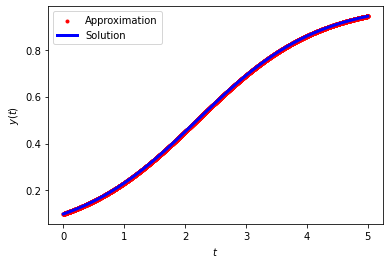

In [4]:
t0 = 0
y0 = 0.1
T = 5
h = 0.001

time, y_approx = euler(logistic, t0, y0, T, h)
solution = (y0 * np.exp(time))/(1 - y0 + y0 * np.exp(time))

max_error = np.max(np.abs(y_approx - solution))
avg_error = np.mean(np.abs(y_approx - solution))
print(f"The maximal error is {max_error}\nThe average error is {avg_error}")

plt.scatter(time, y_approx, label = "Approximation", color = "red", marker = ".", linewidth = 1)
plt.plot(time, solution, label = "Solution", color = "blue", marker = ",", linewidth = 3)
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.legend()
plt.show()

In this case the red line is made of more points that are closer to each other, since the step-size is smaller. There's seems to be evidence of a convergence to the explicit solution!

As a matter of fact, it can be proven that, as $h\rightarrow0$ (so more steps are required to advance in time), errors do not snowball in an uncontrolled way and that, for a fixed time horizon, we indeed recover the solution given by the theory.

However not all that glitters is gold. Let's look at the next example.

#### Example 2: The Unsolvable Equation

Recall the equation I gave at the beginning $y' = \sin\left(yt\right)$. Let's work with that now!

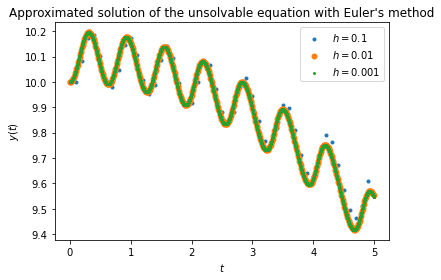

In [5]:
# defining y' = sin(yt)
def unsolvable(t,y):
    return sin(y*t)

#constant
t0 = 0
y0 = 10
T = 5
h1 = 0.1
h2 = 0.01
h3 = 0.001

time1, y_approx1 = euler(unsolvable, t0, y0, T, h1)
time2, y_approx2 = euler(unsolvable, t0, y0, T, h2)
time3, y_approx3 = euler(unsolvable, t0, y0, T, h3)

plt.scatter(time1, y_approx1, marker = ".", label = "$h = 0.1$")
plt.scatter(time2, y_approx2, marker = ".", label = "$h = 0.01$", linewidth = 3)
plt.scatter(time3, y_approx3, marker = ".", label = "$h = 0.001$", linewidth = 0.02)
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.title("Approximated solution of the unsolvable equation with Euler's method")
plt.legend()
plt.show()

All nice and beautiful. But what happens when we make $T = 1000$?

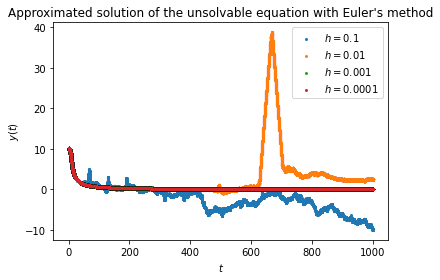

In [6]:
#constant
t0 = 0
y0 = 10
T = 1000
h1 = 0.1
h2 = 0.01
h3 = 0.001
h4 = 0.0001

time1, y_approx1 = euler(unsolvable, t0, y0, T, h1)
time2, y_approx2 = euler(unsolvable, t0, y0, T, h2)
time3, y_approx3 = euler(unsolvable, t0, y0, T, h3)
time4, y_approx4 = euler(unsolvable, t0, y0, T, h4)

plt.scatter(time1, y_approx1, marker = ".", label = "$h = 0.1$", linewidth = 0.02)
plt.scatter(time2, y_approx2, marker = ".", label = "$h = 0.01$", linewidth = 0.02)
plt.scatter(time3, y_approx3, marker = ".", label = "$h = 0.001$", linewidth = 0.02)
plt.scatter(time4, y_approx4, marker = ".", label = "$h = 0.0001$", linewidth = 0.02)
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.title("Approximated solution of the unsolvable equation with Euler's method")
plt.legend()
plt.show()

That's funny, isn't it? We have just changed the time interval and some the solutions diverge from the seemingly correct one., represented by the red and green lines. From Euler's method we have the guarantee that as $h\rightarrow 0$ the maximal distance between the approximation and the original solution will indeed be 0. So what has happened here?

The thing is that the previous theorical guarantee deals with the notion of _convergence_. I'm sad to tell you that convergence does not tell the whole story, though. To properly analyse a numerical method one must also consider the notion of _stability_. So, if we solve with different initial conditions $y_0$ and $\bar{y_0}$, are the computed solutions close?

Let's look at an example to analyse what I mean.

#### Example 3: Malthus' Equation

Consider a basic Malthus equation with negative growth rate ($r>0$)
$$
\begin{cases}
y' = -ry \\
y(0) = 1
\end{cases}
$$

whose solution is $e^{-rt}$. In this case the system of the difference equation becomes $$ y_{n+1} = y_n - rhy_n = y_n(1-rh) $$

Solving the equation we get $$y_n = (1-rh)^n$$

From here, we easily see than $y_n$ converges iff $|1-rh| < 1$ and diverges iff $|1-rh| > 1$. Therefore, with $r>0$ we have that **the asymptotic behaviour** will be extremely different from that of the actual solution when $h > \frac{2}{r}$.

For a clear example, let's take $ r = 1 $. In this case $\frac{2}{r} = 2$, so we expect the $y_n$ to diverge for $h > 2$ . Is it actually so?

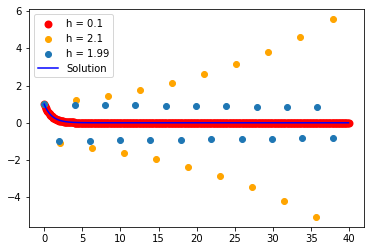

In [7]:
r = 1
h1 = 0.1
h2 = 2.1
h3 = 1.99
t0 = 0
y0 = 1
T = 40

def malthus(t,y):
    return -r * y

time1, y_approx1 = euler(malthus, t0, y0, T, h1)
time2, y_approx2 = euler(malthus, t0, y0, T, h2)
time3, y_approx3 = euler(malthus, t0, y0, T, h3)
solution = np.exp(-r * time1)

plt.scatter(time1, y_approx1, color = "red", marker = ".", linewidth = 5, label = "h = 0.1")
plt.scatter(time2, y_approx2, color = "orange", label = "h = 2.1")
plt.scatter(time3, y_approx3, label = "h = 1.99")
plt.plot(time1, solution, color = "blue", label = "Solution")
plt.legend()
plt.show()

Some of you might see some hints to deterministic chaos, but it is out of the scope of the document. What we can see it that when $h < 2$ and really small it is the closest to the solution. When $h = 1.99$, so still within the boundary, it has initially two stable points which slowly converge towards the solution. Instead, when are just slightly above 2, there you have a divergent solution. This condition exactly satisfies the previous theoretical claims!

More generally, the key quantity to understand the error is given by the magnitude of $\frac{\partial f(t,y)}{\partial y}$ (recall that the general equation is of the type $y' = f(t,y)$). This term tells you the "local" sensititivity of the equation. Euler's method will usually become unstable when $$h > \frac{1}{\left|\frac{\partial f}{\partial y}\right|}$$

Now, going back to *Example 2* we have that $f(t,y) = sin(ty)$ so that

$$\frac{\partial f(t,y)}{\partial y} = t\cdot cos(ty)$$

Doing simple mathematical kung-fu, we get $h > \frac{1}{|t\cdot cos(ty)|} > \frac{1}{t}$ it can be expected to have unstability at time $t \sim \frac{1}{h}$.

For the previous function, let's analyse the different cases
* $h = 0.1 \implies t \sim 10$ (blue)
* $h = 0.01 \implies t \sim 100$ (orange)
* $h = 0.001 \implies t \sim 1000$ (green)
* $h = 0.0001 \implies t \sim 10000$ (red)

As we can see from the graphs, we blue and orange lines display such behaviour around those values. Therefore, we should expect the green and red lines to become unstable, for values much larger than $t = 1000$! 

# Concluding Remarks

Congrats if you've come this far! If you spot mistakes, _lemme know_! Grazie